In [1]:
# !pip install openpyxl
import json
from typing import DefaultDict
import copy
import pandas as pd
from pandas import DataFrame
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

In [2]:
#Disesuaikan dengan directory data Stocklist.xlsx, excluded_word.xlsx, dan result.json
stock_table = pd.read_excel(r'files\StockList.xlsx')
excluded_word = pd.read_excel(r'files\excluded_word.xlsx')

In [3]:
with open('result.json', 'rb') as fp:
    data = json.load(fp)

In [4]:
counter = DefaultDict(int)
bydate = DefaultDict(str)
buffer_date = ''

In [5]:
for chats in data['messages'] :
    try :
        if chats['text'] != '':
            tanggal = chats["date"].split("T")[0]
            pengirim = chats["from"]
            teks = chats["text"].replace("\n"," ").replace(",", " ").replace("."," ").lower()
            teks_perkata = teks.split(" ")
            kode_saham = []
            if tanggal != buffer_date :
                counter = DefaultDict(int)
            else :
                pass
            cek_double = []
            for x in teks_perkata :
                if x not in cek_double :
                    if x in stock_table.Kode.values :
                        if x not in excluded_word.values :
                            kode_saham.append(x)
                            cek_double.append(x)
                            counter[x]+=1
                            bydate[tanggal]=copy.copy(counter)
                        else :
                            continue
                    else :
                        continue
                else :
                    continue
            buffer_date = tanggal
#             print(f'{tanggal} | {pengirim} : {teks} - {kode_saham}')
        else :
            continue
    except :
        continue

In [6]:
#Input stockcode
stockcode = input('Masukkan kode saham : ')
mention_counter = [bydate[x][stockcode] for x in bydate]
mention_date = [x for x in bydate]

df = DataFrame([mention_date,mention_counter]).transpose()
df.columns = ('date','mentions')

#Input tanggal
start_date = input('Masukkan tanggal awal (Format: yyyy-mm-dd) : ')
finish_date = input('Masukkan tanggal akhir (Format: yyyy-mm-dd) : ')

print("")
df.tail()

Masukkan kode saham : antm
Masukkan tanggal awal (Format: yyyy-mm-dd) : 2019-01-01
Masukkan tanggal akhir (Format: yyyy-mm-dd) : 2019-12-31



,date,mentions
527,2021-04-07,10
528,2021-04-08,32
529,2021-04-09,9
530,2021-04-10,1
531,2021-04-11,0


In [9]:
dfa = df[(df['date'] >= '2019-01-01') & (df['date'] <= '2019-12-31')]
dfa

,date,mentions
0,2019-10-18,0
1,2019-10-19,0
2,2019-10-20,0
3,2019-10-21,0
4,2019-10-22,0
...,...,...
61,2019-12-27,0
62,2019-12-28,0
63,2019-12-29,0
64,2019-12-30,0


In [10]:
#Cek ekstensi .JK di kode saham
check_stockcode = stockcode.find(".JK")

if check_stockcode == -1:
    stockcode = (stockcode+".JK")
else:
    stockcode

#Input stockcode ke Yahoo Finance    
stockinfo = yf.download(stockcode, start="{}".format(start_date), end="{}".format(finish_date))
stock_price = stockinfo['Adj Close']

#Mengambil Nama Perusahaan
company_info = yf.Ticker("{}".format(stockcode))
company_name = company_info.info["longName"]


[*********************100%***********************]  1 of 1 completed


In [11]:
stock_price.tail()

Date
2019-12-20    826.162964
2019-12-23    821.186096
2019-12-26    836.116760
2019-12-27    831.139832
2019-12-30    836.116760
Name: Adj Close, dtype: float64

In [13]:
dfprice = DataFrame(stock_price)
dfprice['date'] = dfprice.index
dfprice.shape

(257, 2)

In [ ]:
dfinal = pd.concat([dfa, dfprice], axis=1)

In [25]:
dfa_date = dfa['date'].tolist()
# dfa_date
dfp1 = dfprice[dfprice['date'].isin(dfa_date)]
dfp1['date']=dfp1['date'].astype(str)
dfp1['date'].tolist()
dfa1 = dfa[dfa['date'].isin(dfp1['date'].tolist())]
dfa1.shape
# dfp1['date'].tolist()

<ipython-input-25-c1d7211a8a65>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp1['date']=dfp1['date'].astype(str)


(50, 2)

In [35]:
dfa1['price'] = dfp1['Adj Close'].tolist()
dfa1['mentions'] = (dfa1['mentions']/dfa1['mentions'].max())*100
dfa1['price'] = (dfa1['price']/dfa1['price'].max())*100
dfa1

<ipython-input-35-117e2fd74334>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa1['price'] = dfp1['Adj Close'].tolist()
<ipython-input-35-117e2fd74334>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa1['mentions'] = (dfa1['mentions']/dfa1['mentions'].max())*100
<ipython-input-35-117e2fd74334>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,date,mentions,price
0,2019-10-18,0.0,95.897438
3,2019-10-21,0.0,94.871794
4,2019-10-22,0.0,95.384619
5,2019-10-23,0.0,97.948719
6,2019-10-24,0.0,100.000000
7,2019-10-25,0.0,97.948719
9,2019-10-28,0.0,93.846157
10,2019-10-29,25.0,94.871794
11,2019-10-30,0.0,95.384619
12,2019-10-31,75.0,91.282051


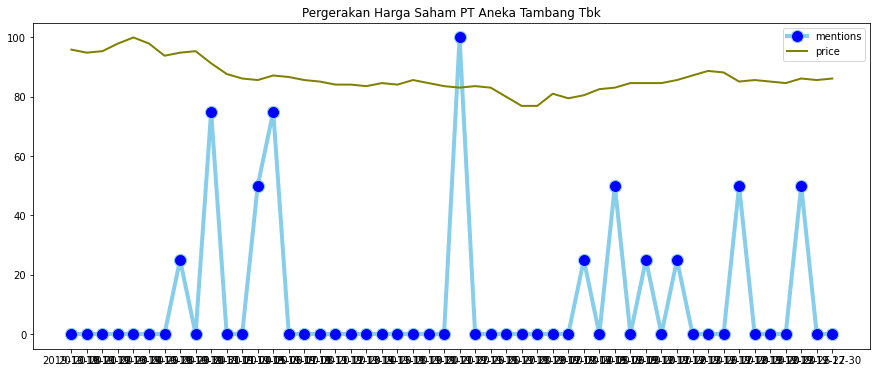

In [39]:
#Menampilkan Grafik Pergerakan Harga Saham
plt.figure(figsize=(15,6))
plt.title("Pergerakan Harga Saham "+company_name)
# plt.plot(stock_price)
plt.plot( 'date', 'mentions', data=dfa1, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'date', 'price', data=dfa1, marker='', color='olive', linewidth=2)
# show legend
plt.legend()

# show graph
plt.show()

# plt.ylabel("Price (IDR)")
# plt.xlabel("Date")
# plt.show()